# Stress Testing with GANs v2.4: Generating FHL based data

*The current notebook implements our revised GAN model (WGAN-GP-Mixed) to generate data based on the FHL public dataset. The improved Generative Adversarial Network is able to work with highly structured multivariate distributions containing both continuous and discrete marginal distributions. The new model is able to overcome any gradient vanishing problems we encountered before and is based on the set of papers described below. The Federal Home Loan Bank Purchased Mortgage dataset is obtained through the [Federal Housing Finance Agency
](https://www.fhfa.gov/DataTools/Downloads/Pages/Public-Use-Databases.aspx) and contains granular loan-level information of US-based mortgages. The dataset contains 82 variables, both continuous and discrete, and has some variables that exhibit a mixed distribution with a Dirac zero delta point. The dataset contains about 65.000 instances making it easily to digest in test settings. The high degree of variability in the data makes it especially challenging to learn the underlying manifold for our GAN model.* 

----

Setup:
  
- [Step 1:](#step1) Mount directory of Google drive (for use in G Colab) and import main and in-house libraries as well as the FHL Dataset
  
- Step 2: Preproccesing of data
  
- Step 3: Implement a composite GAN NN
  
- Step 4: Train the GAN NN 
  
- Step 5: Evaluate Performance 

---

Main papers utilized:
  
- Overview of GANs: [GAN Google](https://developers.google.com/machine-learning/gan/summary)
  
- Seminal GAN paper of Goodfellow et al.: [GAN Seminal paper](https://arxiv.org/abs/1406.2661)
  
- Instability problems with GANs: [Stabilizing GANs](https://arxiv.org/pdf/1910.00927.pdf)
  
- Wasserstein GAN to deal with vanishing gradients: [WGAN](https://arxiv.org/abs/1701.07875) 
  
- Improved WGAN with Gradient Penalty: [WGAN-GP](https://arxiv.org/abs/1704.00028)
  
- How to add custom gradient penalty in Keras: [WGAN and Keras](https://keras.io/examples/generative/wgan_gp/) and [Change model.fit()](https://keras.io/guides/customizing_what_happens_in_fit/)
  
- Multi-categorical variables and GAN: [Multi-categorical GAN](https://arxiv.org/pdf/1807.01202.pdf)
  
- Alternative to WGAN: [DRAGAN](https://arxiv.org/abs/1705.07215)
  
- Conditional DRAGAN on American Express dataset: [DRAGAN & American Express](https://arxiv.org/pdf/2002.02271.pdf)
  
- Mulitvariate KL-divergence by KNN: [KL by KNN](https://ieeexplore.ieee.org/document/4035959)
  
- Multivariate KL-divergence by  KNN p2: [KL by KNN](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.422.5121&rep=rep1&type=pdf)
  

In [1]:
# Initiate Jupyter Notebook, only run once at start (or when Kernel restarts) 
activated_reload= False
activated_chdir= False
GCOLAB= False

<a id='step1'></a>
## Importing libraries and dataset


Connect to Google Colab Directory containing our repository
(only executed on GColab)

In [2]:
if GCOLAB:
    from google.colab import drive
    import sys
    drive.mount('/content/gdrive/')
    sys.path.append('/content/gdrive/My Drive/Stress Testing with GANs/notebooks')

### Settings & environment setup 

In [3]:
# Settings for auto-completion: In case greedy is turned off and jedi blocks auto-completion
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

# Autoreload modules: in case in-house libraries aren't finalised
if not activated_reload:
    activated_reload= True
    %load_ext autoreload
    %autoreload 2
    

# Set working directory for user to main project directory 
import os 
if not activated_chdir:
    activated_chdir= True
    os.chdir('..')
    print('Working directory: ', os.getcwd())

Working directory:  C:\Users\ilias\Desktop\Stress Testing with GANs-Gdrive\Stress Testing with GANs


### Import all the functions of the source code (including libraries)

In [10]:
# TODO: modularize source code
from src.GAN_functions import *
# Import specific libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [11]:
%config InlineBackend.figure_format = 'png'
np.set_printoptions(precision=2)

In [12]:
%matplotlib inline
import matplotlib.font_manager
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"

### Import the FHL dataset 

We have three general ways of importing the data: 

1. Use a local environment and extract the data from the same environment
2. Use a cloud environment and extract data from the local environment 
3. Use a cloud environment and extract data from the same cloud environment

#### Jupyter notebook on local environment 

In [13]:
if not GCOLAB:
    filename= 'FHLbank.csv'
    path= os.path.join( os.getcwd(), 'data/raw', filename)
    FHL_bank = pd.read_csv(path)

#### Google Colab when importing dataset from local environment  

In [14]:
# Import files module 
from google.colab import files
# Upload PPNR dataset into GColab 
ppnr = files.upload()
# Read the file
import io
ppnr = pd.read_csv(io.BytesIO(ppnr['FHLbank.csv']))
# Convert to the right data type 
ppnr = ppnr.astype(dtype = 'float64') 

ModuleNotFoundError: No module named 'google.colab'

#### Google Colab when importing dataset directly from Google Drive


In [15]:
# Read csv file into Colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Shareable link from the dataset in Google drive 
link= 'https://drive.google.com/file/d/1lqeFxTx3MEZKhwowRWzUKTdYPpwvWDUd/view?usp=sharing'
#we only need the id-key portion of the link
id= '1lqeFxTx3MEZKhwowRWzUKTdYPpwvWDUd'

# Import dataset
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('FHLbank.csv')  
FHL_bank = pd.read_csv('FHLbank.csv')

#### Quick overview of the dataset

The dataset contains 65,703 mortgages derived in 2018, with no missing
values. The median borrower(s) total annual income amounts to
\\$95,000 USD, whereas the median family income of the
immediate area where the house is purchased is only
\\$73,600 USD. The median interest rate is set to 4.63\%
whereas the average rate is slightly lower (4.55\%) indicating that the
interest rate is slightly left-skewed. When looking at the amount
borrowed, we see that the median amount is set to
\\$211,000 USD and an average amount of
\\$237,000 USD, indicating a right-skewed distribution.

In [ ]:
# Missing values 
print('Missing values:', FHL_bank.isnull().values.any())
# Quick overview
display(FHL_bank.head())

In [ ]:
cols= ['Year', 'Income', 'CurAreY', 'LTV', 'Rate', 'Amount']
FHL_bank[cols].describe()

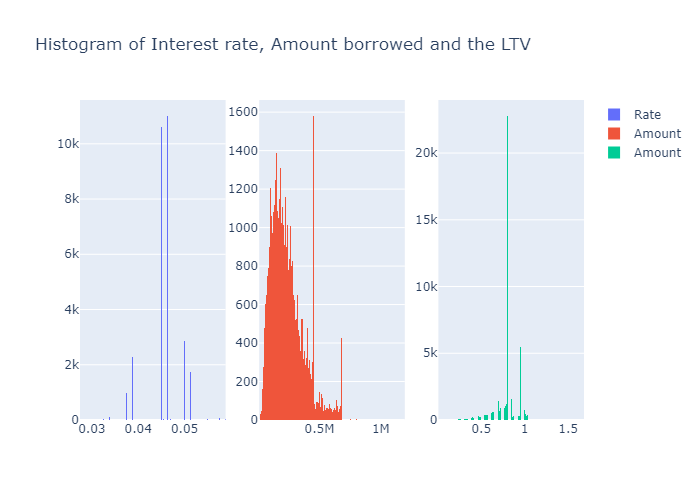

In [9]:
fig = make_subplots(rows=1, cols=3, )
fig.add_trace( go.Histogram( x= FHL_bank['Rate'], name= 'Rate' ), row=1, col=1,  )
fig.add_trace( go.Histogram( x= FHL_bank['Amount'], name= 'Amount' ), row=1, col=2 )
fig.add_trace( go.Histogram( x= FHL_bank['LTV'], name= 'Amount' ), row=1, col=3 )
fig.update_layout(title_text= 'Histogram of Interest rate, Amount borrowed and the LTV')
# config = {'staticPlot': True}
# fig.show(config= config)
img_bytes = fig.to_image(format="png")
from IPython.display import Image
Image(img_bytes, width= 700)

In [16]:
cols= ['Purpose', 'NumBor', 'BoRace', 'BoGender', 'BoAge']
FHL_bank[cols].describe()

Purpose        NumBor        BoRace      BoGender         BoAge
count  65703.000000  65703.000000  65703.000000  65703.000000  65703.000000
mean       1.341263      1.560538      5.013896      1.401793     48.697137
std        0.475675      0.513952      0.957566      0.609255     20.441281
min        1.000000      1.000000      1.000000      1.000000     18.000000
25%        1.000000      1.000000      5.000000      1.000000     34.000000
50%        1.000000      2.000000      5.000000      1.000000     44.000000
75%        2.000000      2.000000      5.000000      2.000000     58.000000
max        4.000000      4.000000      7.000000      3.000000     99.000000

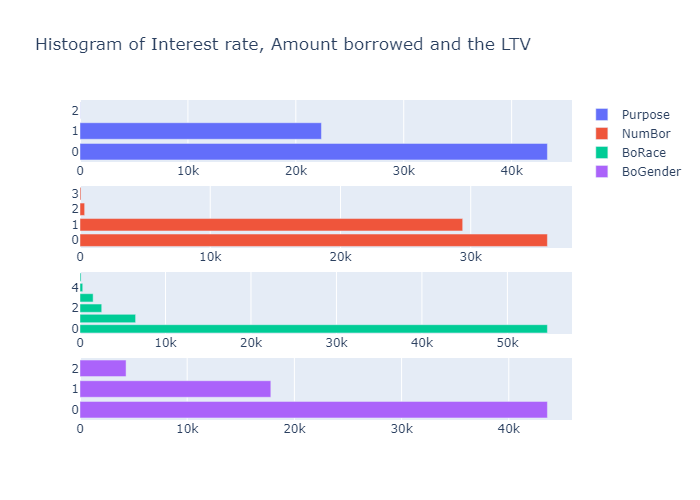

In [18]:
cols= ['Purpose', 'NumBor', 'BoRace', 'BoGender', ]

fig = make_subplots(rows= len(cols), cols=1, )
i= 1
for eachCol in cols:
    fig.add_trace( go.Bar( x= FHL_bank[eachCol].value_counts(), name= eachCol), row= i, col=1)
    i+=1

fig.update_layout(title_text= 'Histogram of Interest rate, Amount borrowed and the LTV')
# config = {'staticPlot': True}
# fig.show(config= config)
img_bytes = fig.to_image(format="png")
from IPython.display import Image
Image(img_bytes, width= 700)

## STEP 1: PREPROCCESING 
--------------
### Separate data into continuous and nominal data 

In [9]:
# Store column names 
redudantColumns=['Year', 'AssignedID', 'FeatureID', 'Rent1', 'Rent2', 'Rent3', 'Rent4', 'RentUt1', 'RentUt2', 'RentUt3',
                'RentUt4', 'ArmIndex', 'ArmMarg', 'PrepayP', 'Bed1', 'Bed2', 'Bed3', 'Bed4',
                'Aff1', 'Aff2', 'Aff3', 'Aff4', 'ArmIndex', 'ArmMarg', 'PrepayP', 'FedFinStbltyPlan', 'GSEREO',
                'AcquDate', 'Coop', 'Product','SellType', 'HOEPA','LienStatus']

continuousColumns= ['MSA', 'Tract', 'MinPer', 'TraMedY', 'LocMedY', 'Tractrat', 'Income', 'CurAreY', 'IncRat',
                   'UPB', 'LTV', 'BoAge', 'CoAge', 'Rate','Amount','Front','Back']

nominalColumns= ['Bank', 'FIPSStateCode', 'FIPSCountyCode', 'MortDate',  'Purpose', 'FedGuar', 'Term', 'AmorTerm', 
                'NumBor', 'First','CICA','BoRace','CoRace','BoGender',
                 'CoGender', 'Geog', 'BoCreditScore', 'CoBoCreditScore', 'PMI', 'Self', 'PropType', 
                'BoEth','Race2','Race3','Race4','Race5','CoEth','Corace2','Corace3','Corace4','Corace5',
                 'SpcHsgGoals','AcqTyp']


# Nominal data 
datasetNominal= FHL_bank[nominalColumns]

# Continuous data (including ordinal data)
datasetContinuous= FHL_bank[continuousColumns]

# Get number of categorical values of each nominal variable 
nominalColumnsValues= datasetNominal.nunique().values

## Preprocess nominal data 
------------------

### One-hot encoding (dummy variables) 
--------------

In [10]:
nameFeatures = nominalColumns
ohe = OneHotEncoder(sparse= False) #create encoder object 
datasetEncoded = ohe.fit_transform(datasetNominal) #transform nominal data 
datasetEncoded = pd.DataFrame(datasetEncoded) #transform output to df 
datasetEncoded.columns = ohe.get_feature_names(nameFeatures) #name columns appropriately 

### Add noise and normalize 
-----------------

In [11]:
# Transforms ohe dataset to list of individual ohe variables 
def variableSeparator(nominalColumnValues, nominalDataset):
    '''
    # nominalColumnValues: A list containing the number of unique values of each variable 
    # nominalDataset: a dataset containing one-hot encoded nominal variables 
    Separates all of the individual variables into a list, so it's easy to perform computations on individual variables 
    '''
    dim= len(nominalColumnsValues)
    variablesSeparated= []
    for eachVariable in range(dim):
        if eachVariable == 0:
            tmp= nominalDataset[:, eachVariable:eachVariable+nominalColumnsValues[eachVariable]]
            variablesSeparated.append(tmp)
            idx= eachVariable+nominalColumnsValues[eachVariable]
        else: 
            tmp= nominalDataset[:, idx:idx+nominalColumnsValues[eachVariable]]
            variablesSeparated.append(tmp)
            idx+= nominalColumnsValues[eachVariable]
            
    return variablesSeparated

In [12]:
# Create noise 
noise = np.random.uniform(0, 0.2, datasetEncoded.shape) #noise level of 0.2 is the standard 
# Add noise to dataset 
dataset_with_noise = datasetEncoded.values + noise 

# Normalize each variable separately (from ohe to probabilities)
datasetNominalNormalized = np.array([]).reshape(len(dataset_with_noise), -1) #initialize 
variablesSeparated= variableSeparator(nominalColumnValues = nominalColumnsValues, nominalDataset= dataset_with_noise)
for eachVariable in variablesSeparated: 
    tmp= ( eachVariable / np.sum(eachVariable, axis= 1)[:, None] )
    datasetNominalNormalized= np.concatenate( (datasetNominalNormalized, tmp), axis= 1)

## Preprocess continuous data 
------------------

### Normalize the data from original distribution to [-1, 1] 


In [13]:
maximum = np.max(datasetContinuous)
minimum = np.min(datasetContinuous)
datasetContinuousNormalized= ( 2 * (datasetContinuous - minimum) / (maximum - minimum) - 1 )

## Choose dataset to work with 
-------------


In [14]:
dataset= np.concatenate((datasetContinuousNormalized, datasetNominalNormalized), axis=1) 

In [13]:
os.getcwd()

'C:\\Users\\ilias\\Desktop\\Stress Testing with GANs-Gdrive\\Stress Testing with GANs'

## STEP 2: SETUP GAN MODEL
---------------
- Choose between the Vanilla GAN and the WGAN-GP 

#### GAN 
--------

In [ ]:
## DISCRIMINATOR

# Shape of the dataset 
input_shape= dataset.shape[1]
# Create the discriminator
discriminator = discriminator_setup_CTGAN(input_shape)

## GENERATOR 

# Shape of the latent space of the generator 
latent_dim= 100 #used in many papers 
# create the generator
generator = generator_setup_CTGAN(input_shape, latent_dim,)

## GAN

# create the gan
gan_model = gan_setup(generator, discriminator)

#### WGAN-GP
---------
- Will be modified to easier compile the model (WIP)

In [17]:
############################### INITIALIZE PARAMETERS #########################



# Optimizer for both the networks
#learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)



# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function
def discriminator_loss(Xreal, Xfake):
    real_loss = tf.reduce_mean(Xreal)
    fake_loss = tf.reduce_mean(Xfake)
    return fake_loss - real_loss


# Define the loss functions to be used for generator
def generator_loss(Xfake):
    return -tf.reduce_mean(Xfake)


# Epochs to train
epochs = 1000
noise_dim= 512
batch_size= 512

# MODEL 
d_model = discriminator_setup_WGANGP(dataset.shape[1])

g_model = generator_setup_WGANGP_GENERIC(dataset.shape[1],noise_dim, 256, 2, 
                                         nominalColumnsValues, nominalColumns, datasetContinuousNormalized.shape[1])
# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=5,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)


# Custom callback to get KL-divergence 
cbk= GANMonitor(dataset, 1000, noise_dim, 10)

## STEP 3: TRAIN GAN
-----------------
- Choose between the Vanilla GAN and the WGAN-GP 

#### Quick overview of the dataset

The dataset contains 65,703 mortgages  derived in 2018, with no missing values. The median borrower(s) total annual income amounts to \\$95,000 USD, whereas the median family income of the immediate area where the house is purchased is only \\$73,600 USD. The median interest rate is set to 4.63% whereas the average rate is slightly lower (4.55%) indicating that the interest rate is slightly left-skewed. When looking at the amount borrowed, we see that the median amount is set to \\$211,000 USD and an average amount of \\$237,000 USD, indicating a right-skewed distribution. 

#### BASIC GAN 

In [17]:
# Missing values 
print('Missing values:', FHL_bank.isnull().values.any())
# Quick overview
display(FHL_bank.head())

Missing values: False


Year  AssignedID     Bank  FIPSStateCode  FIPSCountyCode    MSA  \
0  2018     2131406  Atlanta             24              21  47900   
1  2018     2131407  Atlanta             24              17  47900   
2  2018     2131408  Atlanta             51             153  47900   
3  2018     2131409  Atlanta             51              59  47900   
4  2018     2131410  Atlanta             24               5  12580   

    FeatureID    Tract  MinPer  TraMedY  ...  Corace2  Corace3  Corace4  \
0  9999999999  7512.01   29.85    93261  ...        6        6        6   
1  9999999999  8509.04   67.24   112623  ...        6        6        6   
2  9999999999  9012.36   40.76   140156  ...        6        6        6   
3  9999999999  4221.02   75.97    89250  ...        8        8        8   
4  9999999999  4924.02   64.56    81397  ...        8        8        8   

   Corace5  HOEPA  LienStatus  SpcHsgGoals  FedFinStbltyPlan  AcqTyp  GSEREO  
0        6      2           1            2                 2       1       2  
1        6      2           1            2                 2       1       2  
2        6      2           1            2                 2       1       2  
3        8      2           1            2                 2       1       2  
4        8      2           1            2                 2       1       2  

[5 rows x 82 columns]

In [55]:
cols= ['Year', 'Income', 'CurAreY', 'LTV', 'Rate', 'Amount']
FHL_bank[cols].describe()

Year        Income        CurAreY           LTV          Rate  \
count  65703.0  6.570300e+04   65703.000000  65703.000000  65703.000000   
mean    2018.0  1.126889e+05   75020.088885      0.771016      0.045547   
std        0.0  1.021151e+05   13510.576005      0.147873      0.003560   
min     2018.0  1.100400e+04   18600.000000      0.008000      0.027500   
25%     2018.0  6.349200e+04   65800.000000      0.720000      0.043800   
50%     2018.0  9.500000e+04   73600.000000      0.800000      0.046300   
75%     2018.0  1.370350e+05   80600.000000      0.850000      0.047500   
max     2018.0  9.614088e+06  134800.000000      1.680000      0.058800   

             Amount  
count  6.570300e+04  
mean   2.375626e+05  
std    1.320771e+05  
min    1.040000e+04  
25%    1.399200e+05  
50%    2.110000e+05  
75%    3.070000e+05  
max    1.190000e+06

In [ ]:
## Train model
n_epochs= 10
batch_size= len(dataset)
train_gan(discriminator, generator, gan_model, dataset, latent_dim, n_epochs, batch_size,True,
     'desktop') #saves generator after every epoch 

#### WGAN-GP

Shape of your Data Set loaded: (65703, 82)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  9
    Number of Integer-Categorical Columns =  33
    Number of String-Categorical Columns =  2
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  8
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  1
    Number of ID Columns =  1
    Number of Columns to Delete =  28
    82 Predictors classified...
        This does not include the Target column(s)
        29 variables removed since they were ID or low-information variables
9 numeric variables in data exceeds limit, taking top 30 variables
Number of All Scatter Plots = 45


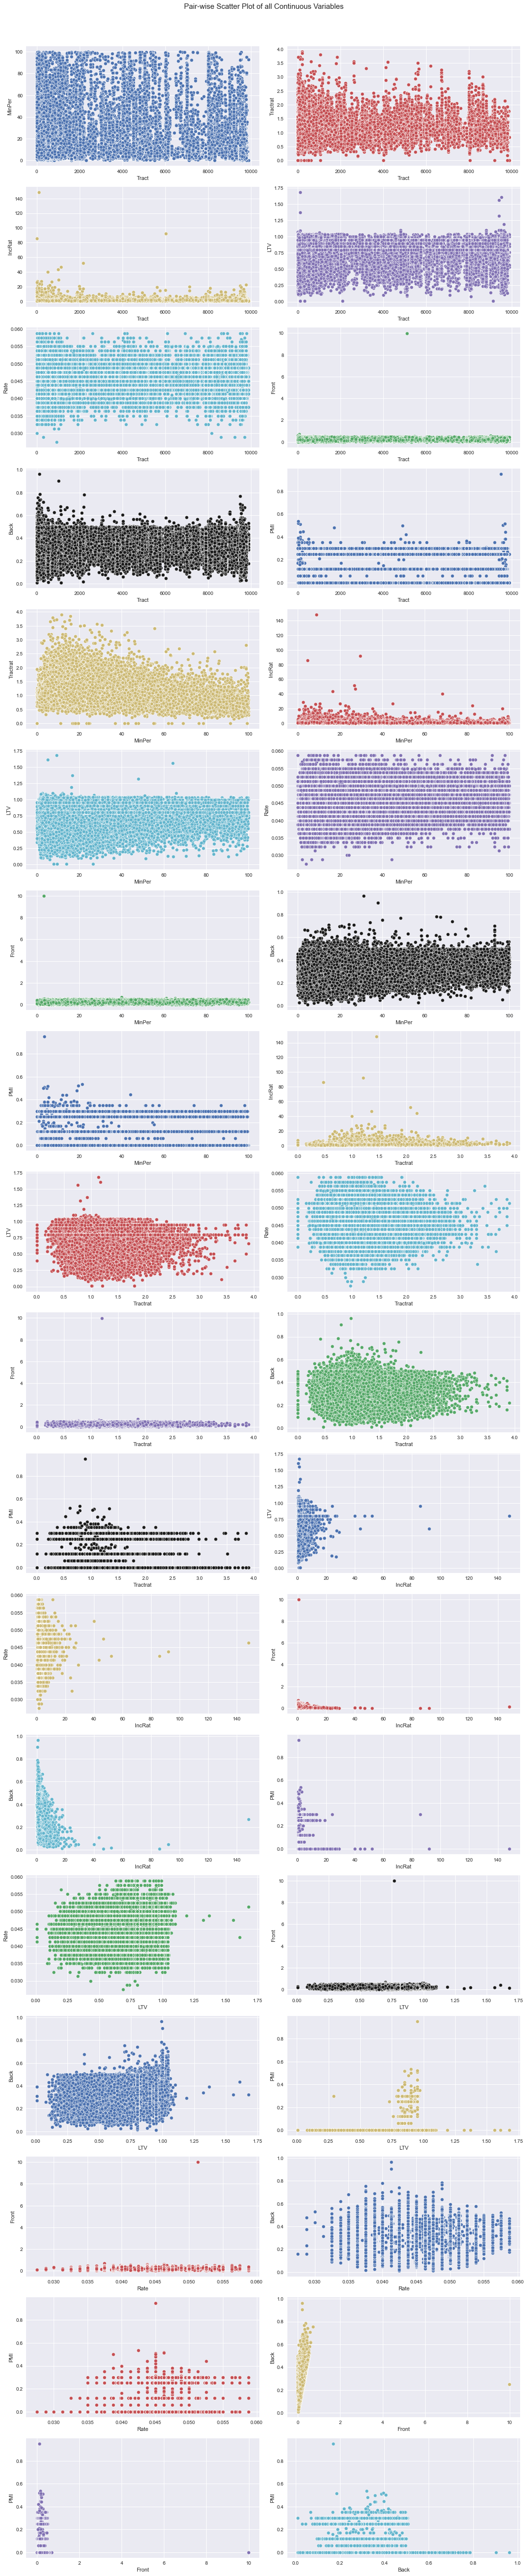

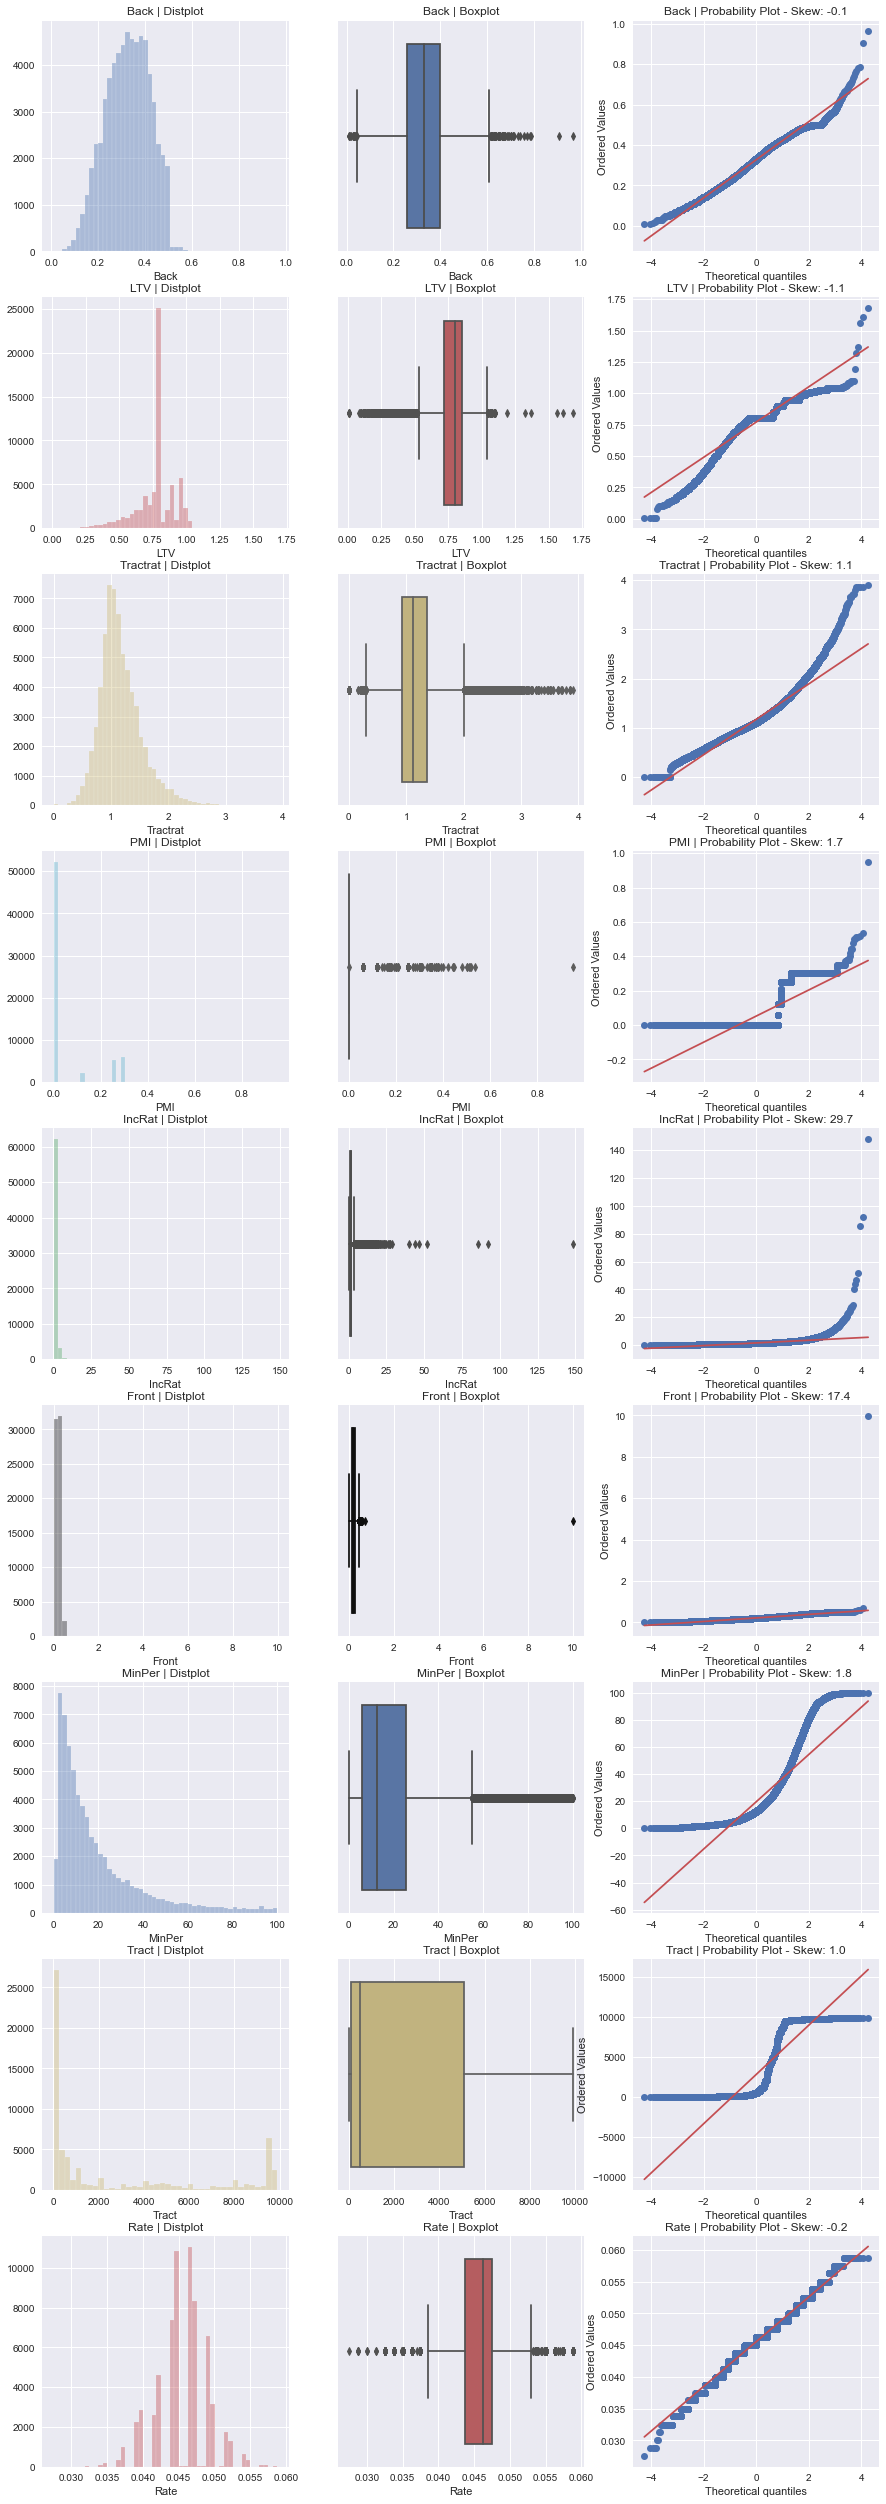

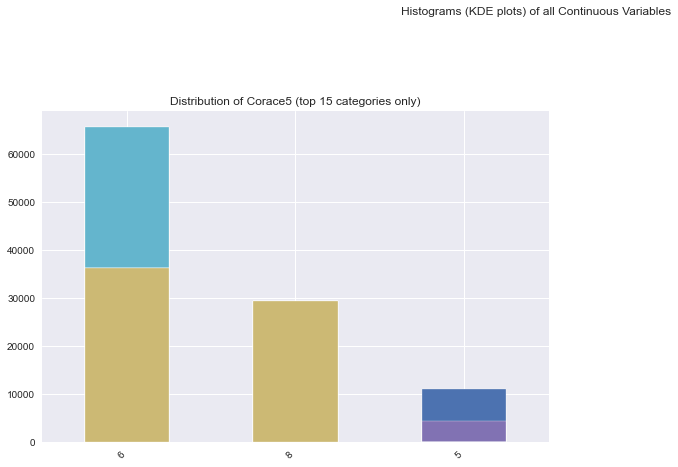

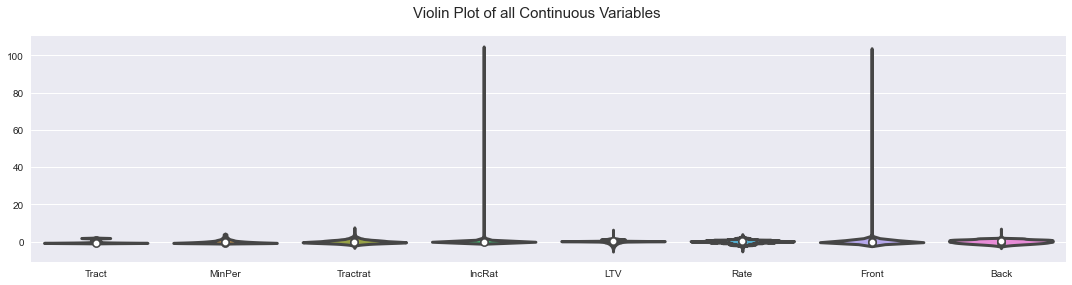

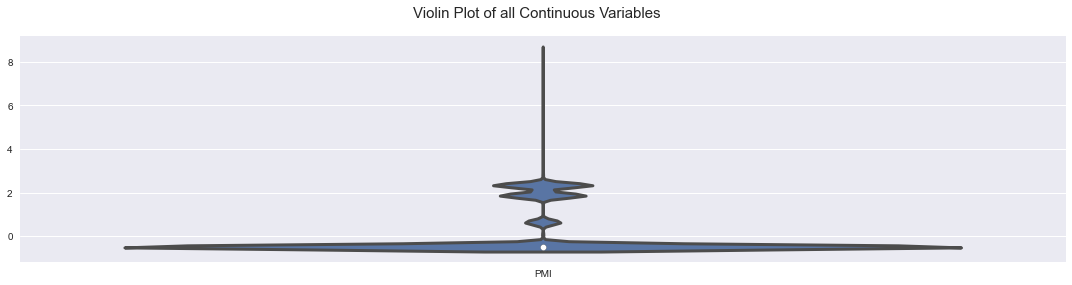

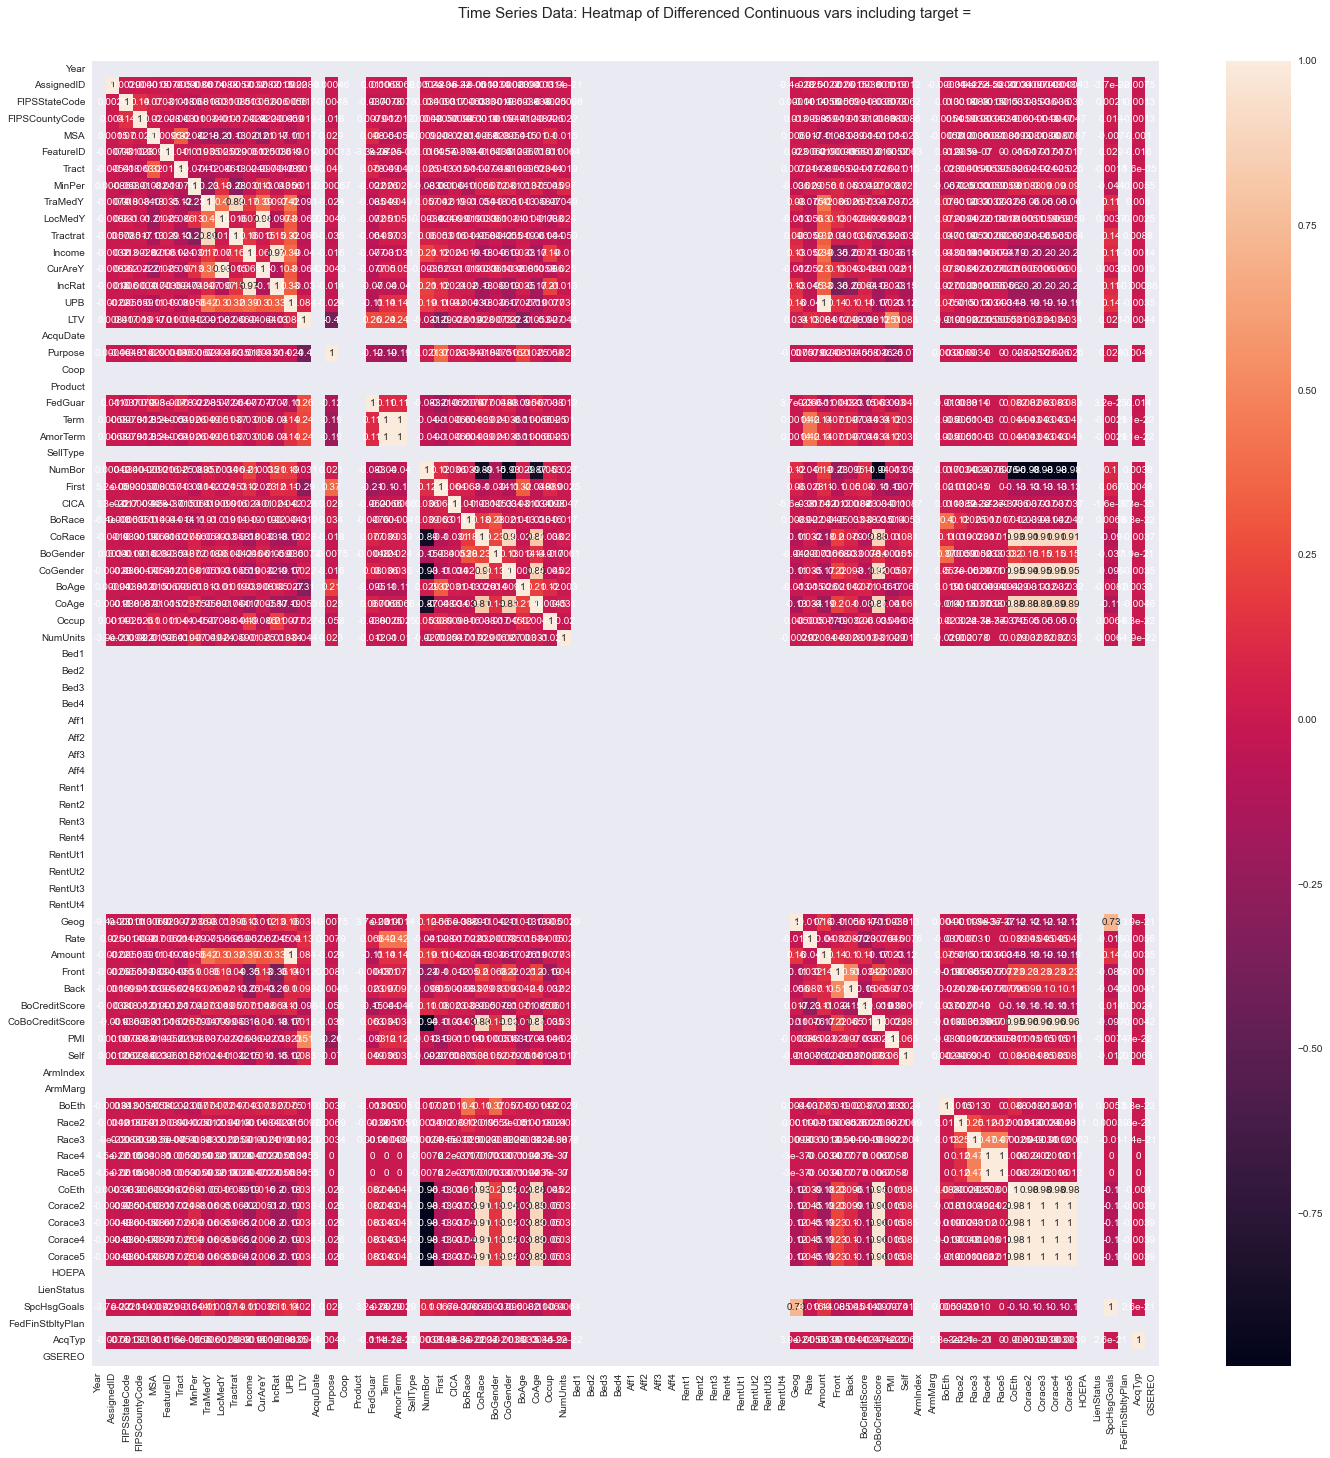

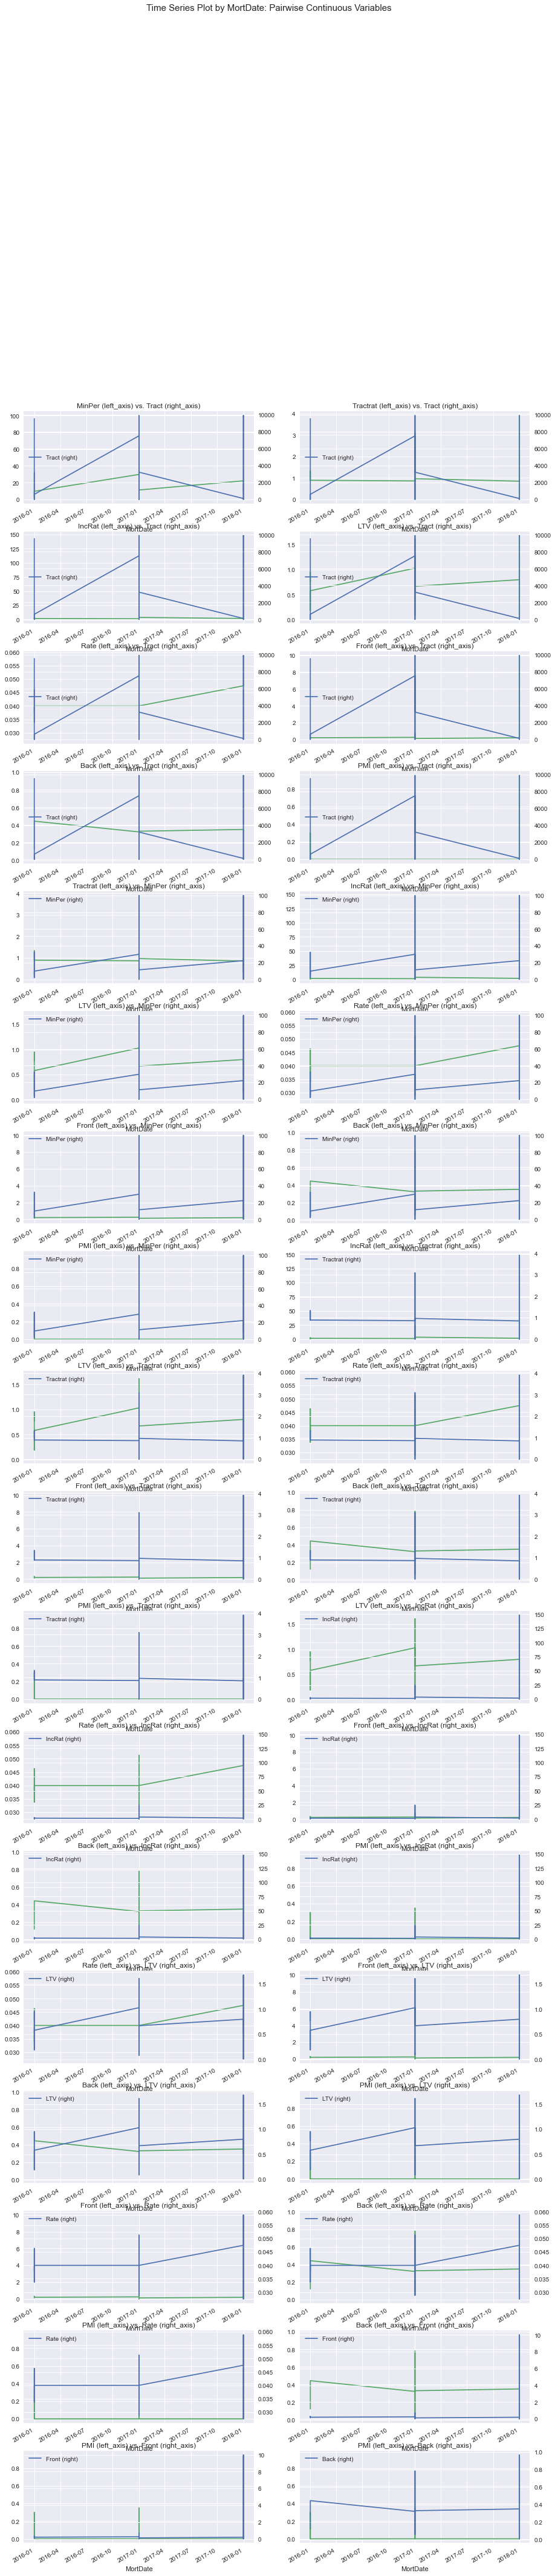

ValueError: Image size of 1440x69840 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1440x69840 with 387 Axes>

Time to run AutoViz (in seconds) = 190.595

 ###################### VISUALIZATION Completed ########################


In [22]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
df = AV.AutoViz(path)

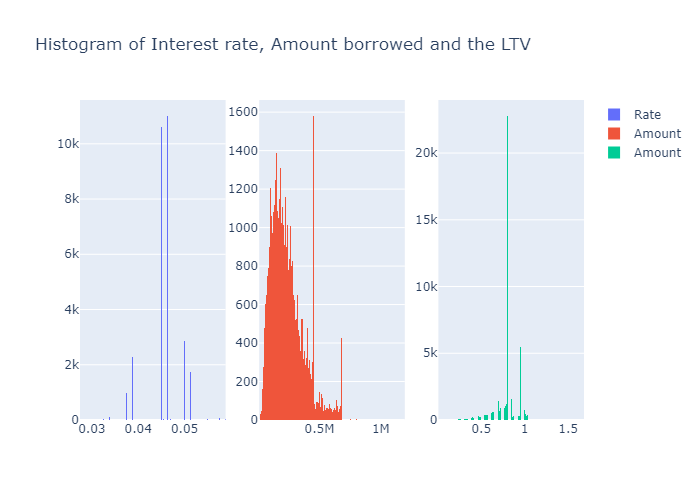

In [108]:
fig = make_subplots(rows=1, cols=3, )
fig.add_trace( go.Histogram( x= FHL_bank['Rate'], name= 'Rate' ), row=1, col=1,  )
fig.add_trace( go.Histogram( x= FHL_bank['Amount'], name= 'Amount' ), row=1, col=2 )
fig.add_trace( go.Histogram( x= FHL_bank['LTV'], name= 'Amount' ), row=1, col=3 )
fig.update_layout(title_text= 'Histogram of Interest rate, Amount borrowed and the LTV')
# config = {'staticPlot': True}
# fig.show(config= config)
img_bytes = fig.to_image(format="png", )
from IPython.display import Image
Image(img_bytes)

#### Quick overview of the dataset


In [93]:
%config InlineBackend.figure_format = 'retina'



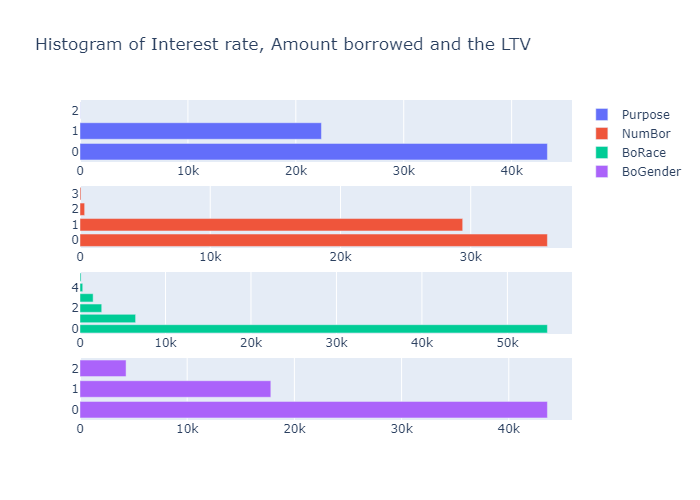

In [106]:
cols= ['Purpose', 'NumBor', 'BoRace', 'BoGender']

fig = make_subplots(rows= len(cols), cols=1, )
i= 1
for eachCol in cols:
    fig.add_trace( go.Bar( x= FHL_bank[eachCol].value_counts(), name= eachCol), row= i, col=1)
    i+=1

fig.update_layout(title_text= 'Histogram of Interest rate, Amount borrowed and the LTV')

# config = {'staticPlot': True}
# fig.show(config= config)
img_bytes = fig.to_image(format="png", )
from IPython.display import Image
Image(img_bytes)

In [18]:
## Train model
history = wgan.fit(dataset, batch_size= batch_size, epochs= epochs, callbacks= [cbk])

## Save Generator
!mkdir -p saved_model
g_model.save('/content/gdrive/My Drive/Stress Testing with GANs/generator_model')

Epoch 1/1000
129/129 [==============================] - 7s 51ms/step - d_loss: -2.4847 - g_loss: -0.4228
Epoch 2/1000
129/129 [==============================] - 6s 47ms/step - d_loss: -0.8246 - g_loss: 0.1006
Epoch 3/1000
129/129 [==============================] - 6s 47ms/step - d_loss: -0.3939 - g_loss: 0.9973
Epoch 4/1000
129/129 [==============================] - 6s 48ms/step - d_loss: -0.3290 - g_loss: 0.7273
Epoch 5/1000
129/129 [==============================] - 6s 47ms/step - d_loss: -0.2740 - g_loss: 0.6343
Epoch 6/1000
129/129 [==============================] - 6s 47ms/step - d_loss: -0.2525 - g_loss: 0.5731
Epoch 7/1000
129/129 [==============================] - 6s 46ms/step - d_loss: -0.2484 - g_loss: 0.5559
Epoch 8/1000
129/129 [==============================] - 6s 46ms/step - d_loss: -0.2496 - g_loss: 0.5113
Epoch 9/1000
129/129 [==============================] - 6s 46ms/step - d_loss: -0.2517 - g_loss: 0.5305
Epoch 10/1000
129/129 [==============================] - 6s 46m

### Load previous trained model (if applicable)
------------
Choose between local environment OR Google Drive 

#### Load model saved in local environment (change path to desired model) 

In [ ]:
g_model = tf.keras.models.load_model(r'C:\Users\ilias\Desktop\Statistics and Data Science\Jupyter Notebook\Yields.io\Stress Testing with GAN\generator_model_v2')

#### Load model saved in Google Drive 

In [ ]:
g_model = tf.keras.models.load_model(r'/content/gdrive/My Drive/Stress Testing with GANs/generator_model') 

## STEP 4: EVALUATE PERFORMANCE  
-----------------------


### Loss functions for WGAN-GP
----------
WIP 

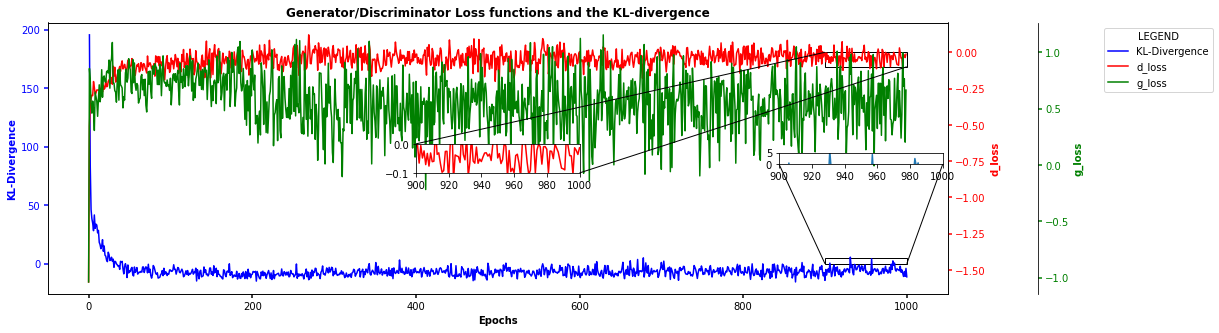

In [19]:
# Plots the loss functions of Discriminator and Generator and the KL-divergence obtained during training 
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

## Main function

def plot_metric(history, cbk):
  g_loss= history.history['g_loss']
  d_loss= history.history['d_loss']
  kl= np.array(cbk.kl_tracker)

  #function to set our spines invisible 
  def make_patch_spines_invisible(ax):
      ax.set_frame_on(True)
      ax.patch.set_visible(False)
      for sp in ax.spines.values():
          sp.set_visible(False)



  # ------------------        
  ## Main Graph 
  # ------------------


  #setup figure 
  fig, host = plt.subplots(figsize=[20, 5])
  fig.subplots_adjust(right=0.75)
  par1 = host.twinx()
  par2 = host.twinx()
  # Offset the right spine of par2.  The ticks and label have already been
  # placed on the right by twinx above.
  par2.spines["right"].set_position(("axes", 1.1))
  # Having been created by twinx, par2 has its frame off, so the line of its
  # detached spine is invisible.  First, activate the frame but make the patch
  # and spines invisible.
  make_patch_spines_invisible(par2)
  # Second, show the right spine.
  par2.spines["right"].set_visible(True)
  # Ready to plot our graphs 
  epochs = range(1, len(g_loss) + 1)
  p1, = host.plot(epochs, kl, 'b', label="KL-Divergence")
  p2, = par1.plot(d_loss, 'r', label="d_loss")
  p3, = par2.plot(g_loss, 'g', label="g_loss")
  # Name labels appropriately 
  host.set_xlabel("Epochs", fontweight='bold')
  host.set_ylabel("KL-Divergence", fontweight='bold')
  par1.set_ylabel("d_loss", fontweight='bold')
  par2.set_ylabel("g_loss", fontweight='bold')
  # Keep coloring uniform across the entire figure 
  host.yaxis.label.set_color(p1.get_color())
  par1.yaxis.label.set_color(p2.get_color())
  par2.yaxis.label.set_color(p3.get_color())
  # Clean up ticks 
  tkw = dict(size=4, width=1.5)
  host.tick_params(axis='y', colors=p1.get_color(), **tkw)
  par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
  par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
  host.tick_params(axis='x', **tkw)
  # Add outside legend and give title
  lines = [p1, p2, p3]
  host.legend(lines, [l.get_label() for l in lines], title= 'LEGEND', bbox_to_anchor=(1.30, 1),)
  plt.title('Generator/Discriminator Loss functions and the KL-divergence', fontweight='bold')


  # ------------------------------
  ## Zoom-ins to get more detail 
  # ------------------------------

  # Zoom into a part of KL-divergence graph
  axins = zoomed_inset_axes(host, 2, loc= 5) # (graph, zoom-in factor, location on graph to display the zoom)
  #What to zoom in on
  axins.plot(epochs, kl)
  x1, x2, y1, y2 = len(kl) - 100, len(kl), 0, 5 # specify the limits
  axins.set_xlim(x1, x2) # apply the x-limits
  axins.set_ylim(y1, y2) # apply the y-limits
  #Add connecting lines to original plot 
  mark_inset(host, axins, loc1=3, loc2=4, fc="none", ec="0", )

  #Zoom into a part of the graph
  axins = zoomed_inset_axes(par1, 2, loc= 10) # (graph, zoom-in factor, location on graph to display the zoom)
  #What to zoom in on
  axins.plot(epochs, d_loss, 'r')
  x1, x2, y1, y2 = len(d_loss) - 100, len(d_loss), -0.1, 0 # specify the limits
  axins.set_xlim(x1, x2) # apply the x-limits
  axins.set_ylim(y1, y2) # apply the y-limits
  #Add connecting lines to original plot 
  mark_inset(par1, axins, loc1=2, loc2=4, fc="None", ec="0", )

  
  
plot_metric(history=history, cbk= cbk)

### Postprocess datasets back to original shape 
-----------------
### Generate a set of Real and Artificial data 
-------------

In [24]:
n_samples= 20000
Xfake, _= generate_artificial_samples(g_model, noise_dim, n_samples)
Xreal, _= generate_real_samples(dataset, n_samples)

#### KL-Divergence 
-----------

In [26]:
print('Estimated KL-divergence:', KLdivergence(Xreal, Xfake, k=5))

Estimated KL-divergence: 0.7347917102524264


### Separate Datasets into Continuous and Nominal data  
------------------

In [ ]:
# Dimensions 
dimContinuous= len(continuousColumns)
dimNominal= len(nominalColumns)

# Artificial Dataset 
Xfake_continuous= Xfake[:,0:dimContinuous] 
Xfake_nominal= Xfake[:, dimContinuous:]

# Real Dataset 
Xreal_continuous= Xreal[:, 0:dimContinuous]
Xreal_nominal= Xreal[:, dimContinuous:]

### Reprocess the Nominal data 
---------------

### Transform data from probabilities to One-hot encoding format 
-----------

In [ ]:
# Divide datasets into separated columns for each nominal variable

XrealSeparated= variableSeparator(nominalColumnValues = nominalColumnsValues, nominalDataset= Xreal_nominal)
XfakeSeparated= variableSeparator(nominalColumnValues = nominalColumnsValues, nominalDataset= Xfake_nominal)

# Function to transform from p() to ohe 
def retransformer(nominalVariable): 
  idx = nominalVariable.argmax(axis=1)
  out = np.zeros_like(nominalVariable,dtype=float)
  out[np.arange(nominalVariable.shape[0]), idx] = 1
  return out

# Transform columns into one-hot encoding format
Xreal_transformed= []
Xfake_transformed= []
for eachVariable in XrealSeparated:
    tmp= retransformer(eachVariable)
    Xreal_transformed.append(tmp)
for eachVariable in XfakeSeparated:
    tmp= retransformer(eachVariable)
    Xfake_transformed.append(tmp)


# Concatenate back into one dataset
Xreal_nominal = np.concatenate((Xreal_transformed), axis=1)
Xfake_nominal = np.concatenate((Xfake_transformed), axis=1)

## Reprocess the Continuous data
--------------

### Renormalize the data from [-1, 1] to original shape
------------


#### Real dataset 

In [ ]:
Xreal_continuous_renormalized= ( ((Xreal_continuous + 1) / 2) * (maximum[:, None].T - minimum[:, None].T) 
                                + minimum[:, None].T)

#### Artificial dataset 

In [ ]:
Xfake_continuous_renormalized= ( ((Xfake_continuous + 1) / 2) * (maximum[:, None].T - minimum[:, None].T) 
                                + minimum[:, None].T)

### Merge all reprocessed data into final matrix/dataFrame
------------

In [ ]:
# Real dataset
Xreal= np.concatenate( (Xreal_continuous_renormalized, Xreal_nominal), axis= 1)
# Artificial dataset 
Xfake= np.concatenate( (Xfake_continuous_renormalized, Xfake_nominal), axis= 1)

## Evaluate similarity between real and artificial distributions 
-----------
#### KL-divergence post-processing (WIP)

- much larger divergence because of nominal data? 


In [ ]:
print('Estimated KL-divergence:', KLdivergence(Xreal, Xfake, k=10))

Estimated KL-divergence: 98.04636952383915


### Plot continuous marginal distributions
------------

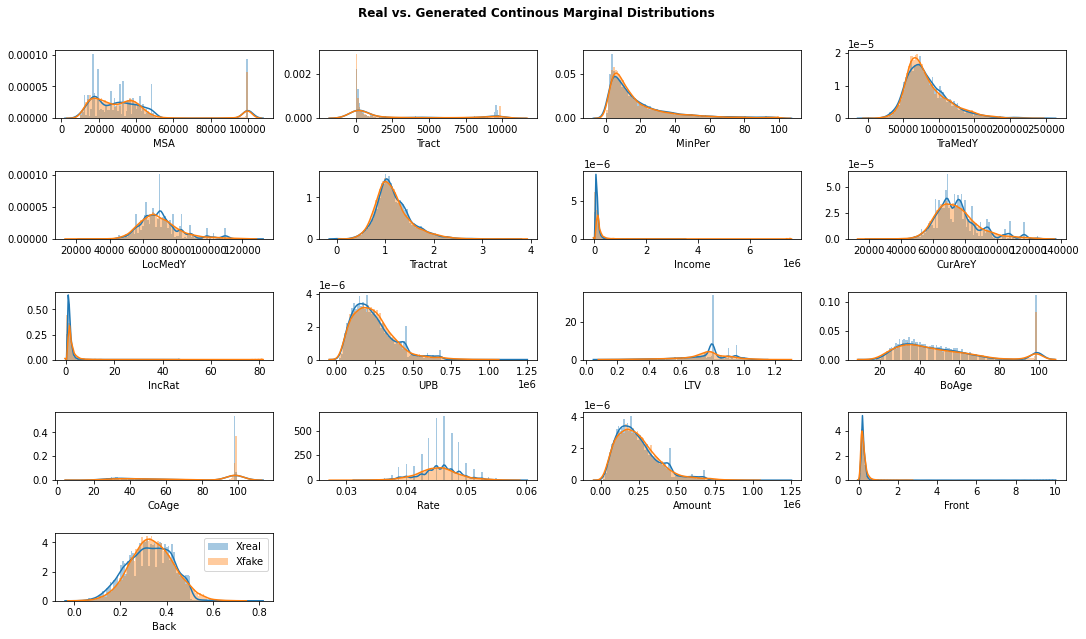

In [ ]:
dim= Xreal_continuous_renormalized.shape[1]
fig= plt.figure(figsize=[15, 30])
for eachDimension in range(dim):
    plt.subplot(dim, 4, eachDimension+1)
    sns.distplot(Xreal_continuous_renormalized[:,eachDimension], bins= 100, label= 'Xreal')
    sns.distplot(Xfake_continuous_renormalized[:,eachDimension], bins= 100, label= 'Xfake')
    plt.xlabel(continuousColumns[eachDimension], fontsize = 10)
plt.legend()
plt.suptitle('Real vs. Generated Continous Marginal Distributions', fontweight= 'bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

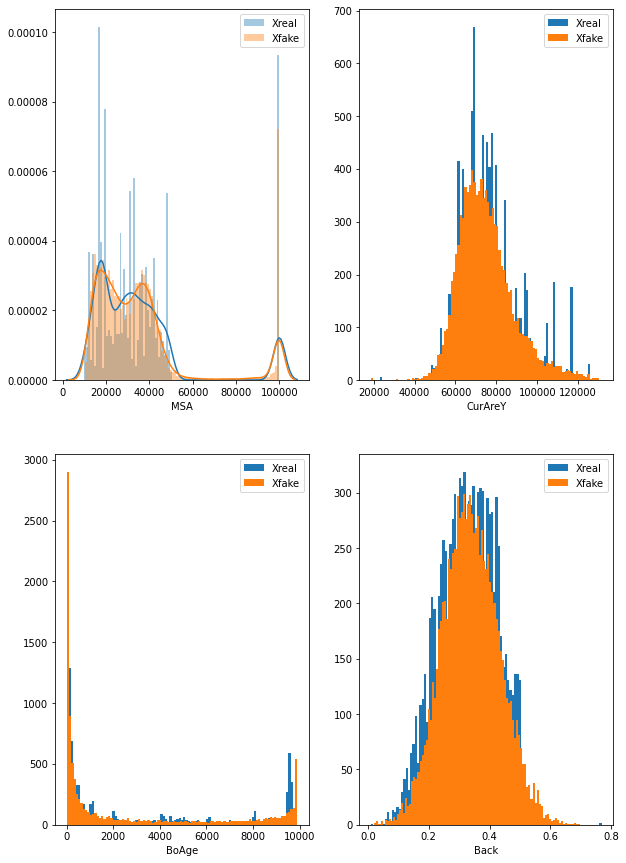

In [ ]:
# Close up of some marginal distributions 

fig= plt.figure(figsize=[10,15])
plt.subplot(2,2,1)
sns.distplot(Xreal_continuous_renormalized[:,0], bins= 100, label= 'Xreal')
sns.distplot(Xfake_continuous_renormalized[:,0], bins= 100, label= 'Xfake')
plt.xlabel(continuousColumns[0], fontsize = 10)
plt.legend();

plt.subplot(2,2,2)
plt.hist(Xreal_continuous_renormalized[:, 7], bins= 100, label= 'Xreal')
plt.hist(Xfake_continuous_renormalized[:, 7], bins= 100, label= 'Xfake')
plt.xlabel(continuousColumns[7], fontsize = 10)
plt.legend();

plt.subplot(2,2,3)
plt.hist(Xreal_continuous_renormalized[:,1], bins= 100, label= 'Xreal')
plt.hist(Xfake_continuous_renormalized[:,1], bins= 100, label= 'Xfake')
plt.xlabel(continuousColumns[11], fontsize = 10)
plt.legend();

plt.subplot(2,2,4)
plt.hist(Xreal_continuous_renormalized[:,-1], bins= 100, label= 'Xreal')
plt.hist(Xfake_continuous_renormalized[:,-1], bins= 100, label= 'Xfake')
plt.xlabel(continuousColumns[-1], fontsize = 10)
plt.legend();

In [ ]:
# Check number of zero values 
print("Xreal -> number of zero values:", np.sum(Xreal_continuous_renormalized[:,1] == 0))
print("Xfake -> number of zero values:", np.sum(Xfake_continuous_renormalized[:,1] == 0))

Xreal -> number of zero values: 0
Xfake -> number of zero values: 0


### Correlations between continuous variables 
----------

In [ ]:
# Correlation structure within the real dataset 
Xreal_corr= pd.DataFrame(data= np.round(np.corrcoef(Xreal_continuous_renormalized, rowvar= False), 2), 
                         columns=continuousColumns,
                        index= continuousColumns)

# Correlation structure within the fake dataset 
Xfake_corr= pd.DataFrame(data= np.round(np.corrcoef(Xfake_continuous_renormalized, rowvar= False), 2), 
                         columns=continuousColumns,
                        index= continuousColumns)

# Difference in correlation structure between the datasets 
X_corr_diff= Xreal_corr - Xfake_corr
X_corr_diff

MSA  Tract  MinPer  TraMedY  ...  Rate  Amount  Front  Back
MSA       0.00   0.00   -0.01    -0.03  ...  0.02   -0.04  -0.24 -0.12
Tract     0.00   0.00   -0.03    -0.06  ...  0.10    0.00  -0.16 -0.14
MinPer   -0.01  -0.03    0.00    -0.01  ... -0.05   -0.01   0.00  0.01
TraMedY  -0.03  -0.06   -0.01     0.00  ... -0.07    0.03   0.07  0.09
LocMedY   0.07  -0.04    0.05     0.01  ... -0.08   -0.02   0.12  0.09
Tractrat -0.12  -0.06   -0.06     0.03  ... -0.03    0.02   0.01  0.05
Income   -0.05  -0.06    0.08     0.18  ...  0.01    0.29  -0.52 -0.06
CurAreY   0.04  -0.01    0.04     0.04  ... -0.06    0.00   0.14  0.10
IncRat   -0.26  -0.13   -0.01     0.15  ...  0.04    0.16  -0.55 -0.16
UPB      -0.09  -0.04    0.02     0.04  ... -0.09    0.01   0.03  0.04
LTV      -0.06   0.01    0.00     0.01  ...  0.02   -0.04   0.04 -0.03
BoAge     0.05   0.04    0.06    -0.07  ...  0.06    0.02  -0.10  0.15
CoAge     0.04   0.01   -0.05    -0.04  ...  0.08    0.07  -0.06  0.03
Rate      0.02   0.10   -0.05    -0.07  ...  0.00   -0.11   0.06  0.02
Amount   -0.04   0.00   -0.01     0.03  ... -0.11    0.00   0.06  0.04
Front    -0.24  -0.16    0.00     0.07  ...  0.06    0.06   0.00  0.09
Back     -0.12  -0.14    0.01     0.09  ...  0.02    0.04   0.09  0.00

[17 rows x 17 columns]

### Plot nominal marginal distributions
------------

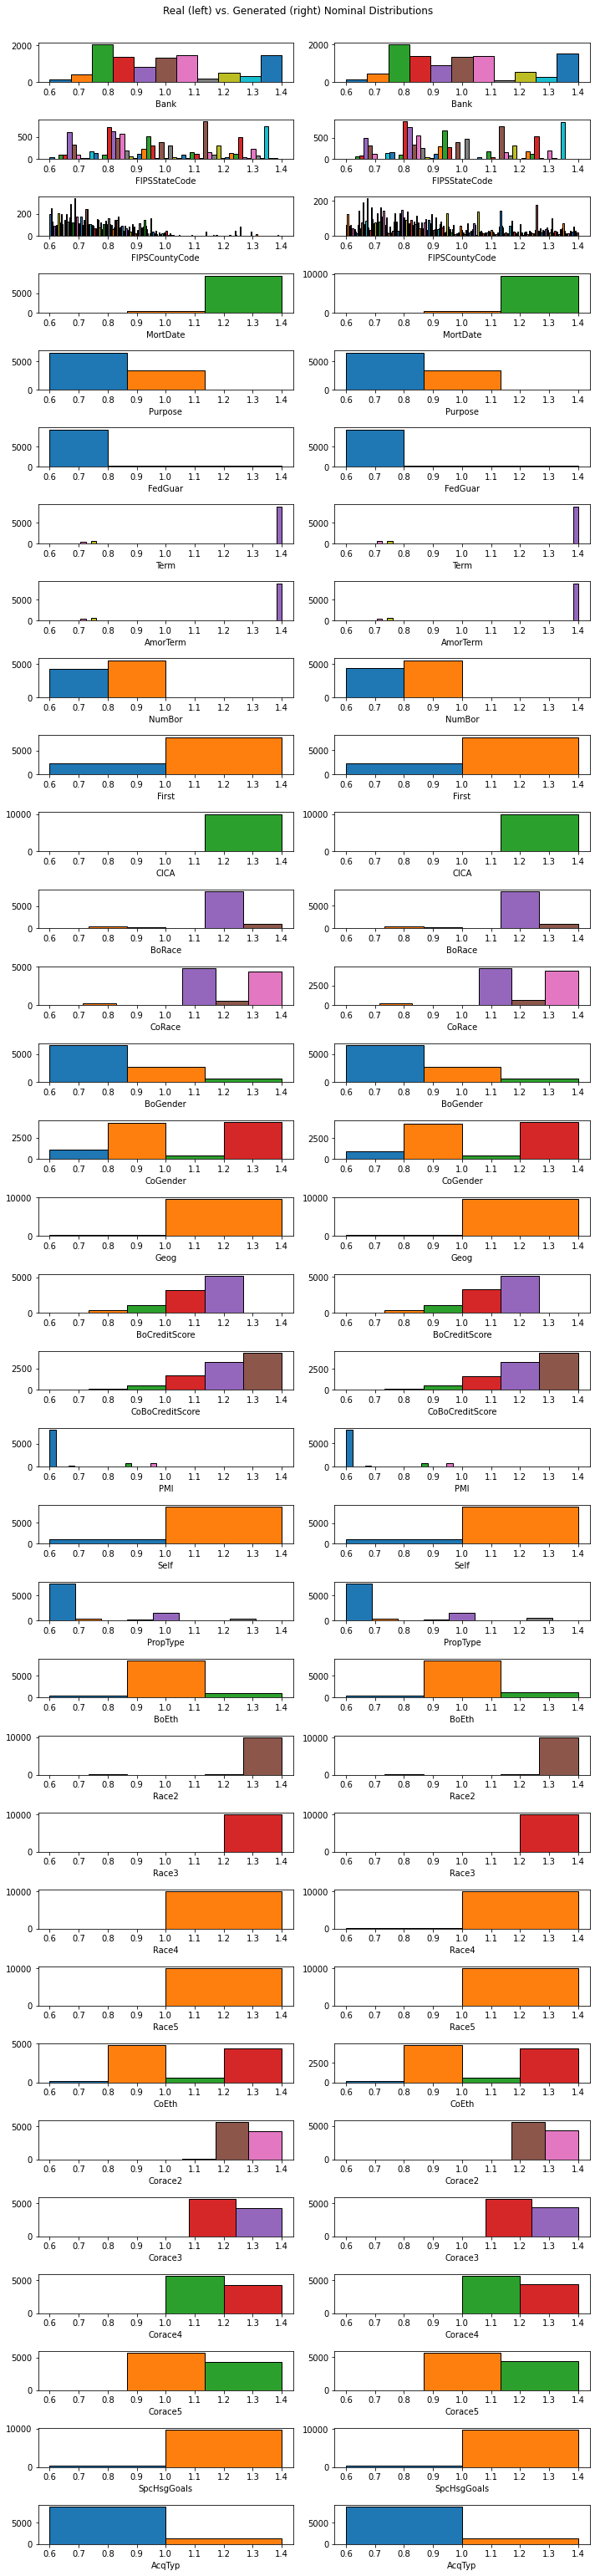

In [ ]:
fig= plt.figure(figsize=[10, 45])
dim= len(nominalColumnsValues)
idx_Xreal=np.arange(1,dim*2,2)
idx_Xfake=np.arange(2,dim*2+2,2)
for eachVariable in range(dim):
    

    plt.subplot(dim, 2, idx_Xreal[eachVariable])
    plt.hist(retransformer(XrealSeparated[eachVariable]), bins=[.5,.5,1.5], ec= 'k')
    plt.xlabel(nominalColumns[eachVariable])
    
    plt.subplot(dim, 2, idx_Xfake[eachVariable])
    plt.hist(retransformer(XfakeSeparated[eachVariable]), bins=[.5,.5,1.5], ec= 'k')
    plt.xlabel(nominalColumns[eachVariable])
    
    
    
plt.suptitle('Real (left) vs. Generated (right) Nominal Distributions');
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

### Train the model further if needed 
---------
- Go back to step 4 afterwards 

In [ ]:
wgan.fit(dataset, batch_size= batch_size, epochs= epochs, callbacks= [cbk])

## STEP 5: Save the Generator and the synthetic dataset   
-----------------------
- If model performance is satisfactory we can go ahead and save our trained Generator together with the synthetic dataset 

####  Create Pandas DataFrame of synthetic generated data
-----------

In [ ]:
#### Create Pandas DataFrame of synthetic generated data ####

## Convert continuous synthetic data to df 

df_Xfake_continuous= pd.DataFrame(data= Xfake_continuous_renormalized, columns= continuousColumns)

## Convert nominal synthetic data to df 

#get all of the nominal variables (in one-hot encoded format)
nominalVariablesList = variableSeparator(nominalColumnValues = nominalColumnsValues, nominalDataset= Xreal_nominal)
#initialize dataframe before loop
df_Xfake_nominal= pd.DataFrame()
#Tranform from one-hot encoding to original shape for each nominal variable 
for eachColumn in range(len(nominalVariablesList )):
  #create dataFrame object 
  tmp= pd.DataFrame(nominalVariablesList[eachColumn])
  #equate column names to unique values of the variable 
  uniqueValues= datasetNominal.iloc[:,eachColumn].unique()
  uniqueValues.sort() #sort values (just like ohe of sklearn does)
  tmp.columns= uniqueValues 
  #condense one-hot encoding back to original shape 
  tmp2= tmp.idxmax(axis='columns')
  #concatenate into one dataFrame containing all of the nominal columns 
  df_Xfake_nominal= pd.concat([df_Xfake_nominal, tmp2], axis= 1)
#name the columns appropriately 
df_Xfake_nominal.columns= nominalColumns

## Merge the continuous and nominal synthetic data to one df 
df_Xfake= pd.concat([df_Xfake_continuous, df_Xfake_nominal], axis= 1)
#match the same layout of the original dataset
df_Xfake= df_Xfake[[i for i in list(FHL_bank.columns) + redudantColumns if i not in list(FHL_bank.columns) or i not in redudantColumns] ]

KeyError: ignored

#### Save Generator and synthetic dataset (Jupyter Notebook)

----------------

In [ ]:
## Save the DataFrame
df_Xfake.to_csv('/content/gdrive/My Drive/Stress Testing with GANs/Datasets/FHL_data.csv')
## Save the trained Generator 
!mkdir -p saved_model
g_model.save('/content/gdrive/My Drive/Stress Testing with GANs/FHL_generator_model')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Stress Testing with GANs/generator_model/assets


#### Save Generator and synthetic dataset (Google Colab)
----------------

In [ ]:
## Save the DataFrame
df_Xfake.to_csv(r'C:\Users\ilias\Desktop\Statistics and Data Science\Jupyter Notebook\Yields.io\Stress Testing with GAN\FHL_synthetic_data.csv')
## Save the trained Generator 
g_model.save(r'C:\Users\ilias\Desktop\Statistics and Data Science\Jupyter Notebook\Yields.io\Stress Testing with GAN\FHL_generator_model')

In [ ]:
####### XGBOOST- IMPORT LIBRARIES NEEDED ##########

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score

#for i in range(Xfake_continuous_renormalized.shape[1]):
Xfake= Xfake_continuous_renormalized[:,:]
## truncation
#Xfake= Xfake.clip(min=0)
Xreal= Xreal_continuous_renormalized[:,:]
Xfake_new= np.ones((n_samples,Xreal_continuous_renormalized.shape[1]+1))
Xfake_new[:,:-1]= Xfake 
Xreal_new= np.zeros((n_samples,Xreal_continuous_renormalized.shape[1]+1))
Xreal_new[:,:-1]= Xreal
df_XGBOOST= np.concatenate( (Xfake_new, Xreal_new), axis=0)

## NOMINAL -> OK! 
Xfake= df_Xfake_nominal.iloc[:7500,:]
Xreal= FHL_bank[nominalColumns]
Xfake_new= np.ones((7500, Xfake.shape[1]+1))
Xfake_new[:,:-1]= Xfake.values
Xreal_new= np.zeros((7500, Xfake.shape[1]+1))
#Xreal_new[:,:-1]= Xreal.values
df_XGBOOST= np.concatenate( (Xfake_new, Xreal_new), axis=0)

X= df_XGBOOST[:,0:-1]
y= df_XGBOOST[:,-1]

seed = 1
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

model = XGBClassifier()
model.fit(X_train, y_train);

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Variable %int: Accuracy: %.2f%%" % (i, accuracy * 100.0))

ValueError: ignored